In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt

In [3]:
# Goals of notebook: Generate A matrices with varying polar decomposition --> Plot the trajectories --> Calculate the LQG cost

In [4]:
def genA(theta, epsilon, delta):

    U = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    P = np.diag([1 - epsilon - delta, 1 - epsilon + delta]) 

    A = U @ P

    # Caley transformation to a continuous time dynamics matrix
    Ac = -1*(np.eye(2) - A) @ np.linalg.inv(np.eye(2) + A)

    return A, Ac   


In [5]:
A, Ac = genA(np.pi/4, 0.1, 0.3)

In [6]:
np.abs(np.linalg.eigvals(A))

array([0.84852814, 0.84852814])

In [7]:
np.linalg.eigvals(Ac)

array([-0.09355812+0.37506687j, -0.09355812-0.37506687j])

In [8]:
def LQG_score(A):
    P = scipy.linalg.solve_continuous_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))

    return np.trace(P @ Q)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/scipy/linalg/_solvers.py:191: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  warnings.warn('Input "a" has an eigenvalue pair whose sum is '


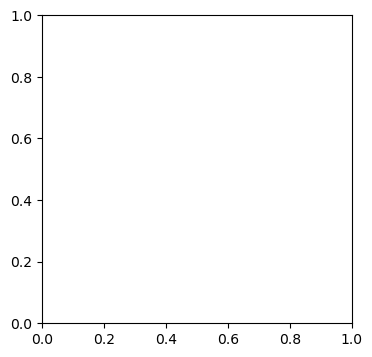

In [10]:
# Plot the spectrum of Ac as theta varies for a few value sof delta
theta = np.linspace(0, np.pi/3, 25)
delta = np.linspace(0, 0.2, 25)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        # try:
        #     assert(np.max(np.real(np.linalg.eigvals(Ac))) < 0)
        # except:
        #     print(delta[j])
        iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)
        lqgscore[i, j] = LQG_score(Ac)
        pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac, np.eye(Ac.shape[0])))[1]

In [11]:
import matplotlib.patches as mpatches

Text(0.5, 0, '$||A - A_{ss}||/||A||$ (a.u.)')

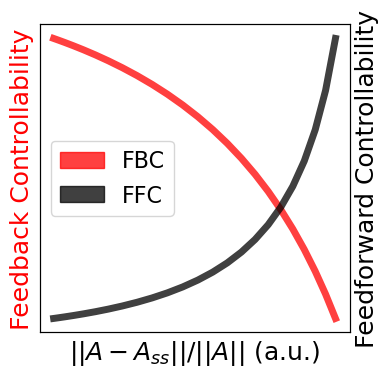

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax2 = ax.twinx()

ax.plot(ssnorm[5, :], lqgscore[5, 0] - lqgscore[5, :], color='r', linewidth=5, alpha=0.75)   
ax2.plot(ssnorm[5, :], pcascore[5, :] - pcascore[5, 0], color='k', linewidth=5, alpha=0.75)
red_patch = mpatches.Patch(color='red', label='FBC', alpha=0.75)
black_patch = mpatches.Patch(color='black', label='FFC', alpha=0.75)
ax.legend(handles = [red_patch, black_patch], loc = 'center left', fontsize=16)
ax.set_xticks([])
ax.set_ylabel('Feedback Controllability', color='red', fontsize=18)
ax2.set_ylabel('Feedforward Controllability', fontsize=18)
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xlabel(r'$||A - A_{ss}||/||A||$' + ' (a.u.)', fontsize=18)
fig.savefig('rotational_dependence.pdf', bbox_inches='tight', pad_inches=0)